In [1]:
import pickle
import pprint
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_score, \
    recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [2]:
import warnings
warnings.filterwarnings("ignore")

style.use('seaborn-whitegrid')
%matplotlib inline

In [3]:
%xmode Plain

Exception reporting mode: Plain


In [4]:
df = pd.read_csv('data/clean_data_encoded_for_regression.csv')

X = df[['gender', 'senior', 'partner', 'dependents', 'tenure', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges',
       'avg_monthly_charges', 'internet_service-fiber_optic',
       'internet_service-no', 'contract-one_year', 'contract-two_year',
       'payment_method-credit_card_auto', 'payment_method-electronic_check',
       'payment_method-mailed_check']]

y = df['churn']

# Stratify our train-test-split so that we have a balanced split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify=y)

#### Upsample with SMOTE to get a balanced dataset

Currently, only 27% of our dataset is categorized as "Churn" (i.e., will leave the telecom company and no longer be a customer this month). In order to train our model better, we are upsampling with SMOTE so that 50% of our dataset is categorized as "Churn". This makes sense because we are more concerned about recall (making sure our model catches nearly everyone who is likely to churn) than it is about precision.

The rationale? It's much cheaper to keep an existing customer than to acquire a new one.

In [5]:
sm = SMOTE(random_state=42, ratio=1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print(y_train.value_counts(), np.bincount(y_train_res))

0    3614
1    1308
Name: churn, dtype: int64 [3614 3614]


### Let's do some quick and dirty analyses to determine which models we should tune further

First we'll do ANOTHER train test split on the training set. We want to make sure that we leave our actual test data (X_test and y_test) alone.

In [6]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train_res, y_train_res, test_size=0.33, random_state=20)

In [7]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtrain, ytrain), model.score(xtest, ytest)


def quick_test_a_few_times(model, X, y, n=10):
    return (pd.DataFrame([quick_test(model, X, y) for j in range(n)],
                         columns=['Train Acc', 'Test Acc'])).mean()

new_model = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
# pred = new_model.predict(X_test)
# Do the test 10 times with a LinearSVC and get the average score
print(quick_test_a_few_times(new_model, X_train_2, y_train_2))


Train Acc    0.771968
Test Acc     0.762285
dtype: float64


In [8]:
def get_scores(model):
    mod = model
    mod = mod.fit(X_train_2, y_train_2)
    predictions = mod.predict(X_test_2)

    print(f'Train accuracy: {mod.score(X_train_2, y_train_2)}')
    print(f'Test accuracy: {mod.score(X_test_2, y_test_2)}')
    print(f'Precision: {precision_score(y_test_2, predictions)}')
    print(f'Recall: {recall_score(y_test_2, predictions)}')
    print()
    print(classification_report(y_test_2, predictions))
    print()

#### Decision Tree

In [9]:
models = [
    {
        'label': 'Logistic Regression',
        'model': LogisticRegression(),
    },
    {
        'label': 'Gradient Boosting',
        'model': GradientBoostingClassifier(),
    },
    {
        'label': 'Random Forest',
        'model': RandomForestClassifier(),
    },
    {
        'label': 'AdaBoost Classifier',
        'model': AdaBoostClassifier(),
    },
    {
        'label': 'Support Vector Classifier',
        'model': SVC(probability=True),
    },
    {   'label': 'Naive Bayes',
        'model': GaussianNB()
    }
]

def evaluate_models(model_types: list):
    for i in range(len(model_types)):
        model = model_types[i]['model']
        print(f'*CURRENT MODEL: {model_types[i]["label"].upper()}*')
        quick_test_a_few_times(model, X_train_2, y_train_2)
        get_scores(model)
        print()

In [10]:
evaluate_models(models)

*CURRENT MODEL: LOGISTIC REGRESSION*
Train accuracy: 0.7719950433705081
Test accuracy: 0.768650461022632
Precision: 0.7490196078431373
Recall: 0.8045492839090144

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1199
           1       0.75      0.80      0.78      1187

   micro avg       0.77      0.77      0.77      2386
   macro avg       0.77      0.77      0.77      2386
weighted avg       0.77      0.77      0.77      2386



*CURRENT MODEL: GRADIENT BOOSTING*
Train accuracy: 0.8764973151590252
Test accuracy: 0.856663872590109
Precision: 0.8645383951682485
Recall: 0.8441449031171019

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1199
           1       0.86      0.84      0.85      1187

   micro avg       0.86      0.86      0.86      2386
   macro avg       0.86      0.86      0.86      2386
weighted avg       0.86      0.86      0.86      2386



*CURRENT MODEL: RA

### Adding in pipeline

In [11]:
model = make_pipeline(StandardScaler(), SVC())
model.fit(X_train_2, y_train_2)
pred = model.predict(X_test_2)

quick_test_a_few_times(model, X_train_2, y_train_2)

Train Acc    0.869017
Test Acc     0.828906
dtype: float64

In [12]:
model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
model.fit(X_train_2, y_train_2)
pred = model.predict(X_test_2)

quick_test_a_few_times(model, X_train_2, y_train_2)

Train Acc    0.870198
Test Acc     0.830557
dtype: float64

In [13]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train_2, y_train_2)


list_of_coeffs = list(sorted(zip(coeffs, X.columns)))

In [15]:
coeffs = decisiontree.feature_importances_ # it's a percentage
list_of_coeffs = list(sorted(zip(coeffs, X.columns)))
pprint.pprint(list_of_coeffs)

[(0.00011409167831465742, 'internet_service-no'),
 (0.0070477030126001134, 'streaming_tv'),
 (0.009140282540468387, 'payment_method-mailed_check'),
 (0.009511174834388798, 'online_backup'),
 (0.01088734377110451, 'payment_method-credit_card_auto'),
 (0.011803944826487433, 'senior'),
 (0.012952902445072762, 'multiple_lines'),
 (0.013816092307929944, 'device_protection'),
 (0.014483528086444118, 'tech_support'),
 (0.015474802991514084, 'partner'),
 (0.015518586711943092, 'dependents'),
 (0.017390934667237797, 'phone_service'),
 (0.01834613024102332, 'gender'),
 (0.023091128861675417, 'online_security'),
 (0.02425285441321493, 'paperless_billing'),
 (0.024539934541962384, 'streaming_movies'),
 (0.028714551564667776, 'contract-two_year'),
 (0.03390283986254155, 'contract-one_year'),
 (0.056400467013065954, 'internet_service-fiber_optic'),
 (0.07390721929082611, 'avg_monthly_charges'),
 (0.08669916169832582, 'total_charges'),
 (0.09532597012994744, 'monthly_charges'),
 (0.13410722104843845,

In [16]:
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train_2, y_train_2)
grad_boost.feature_importances_ # values are between 0 and 1, not normalized
grad_boost.train_score_.mean()

0.699607785690208

In [17]:
s2 = LinearSVC()
s2.fit(X_train, y_train)
s2.coef_ # the absolute value dictates importance

array([[-4.61187417e-02,  3.41732629e-01,  1.17480079e-01,
        -2.69555435e-02, -6.41389197e-02, -2.49526367e-01,
        -2.08208756e-01, -7.90193098e-02, -8.53672254e-02,
         2.72582678e-01, -5.25869091e-01,  2.38690015e-02,
         1.88559323e-02,  2.45614646e-01,  2.58768378e-02,
         3.80854438e-04, -1.66841876e-02,  1.70509579e-01,
        -1.27082613e-01, -3.35982684e-01, -4.75978620e-01,
        -2.53463480e-02,  2.81033599e-01,  1.37378447e-01]])

In [18]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.coef_ # the abosulute value dictates importance

array([[ 2.70983933e-02,  2.29004525e-01, -1.04343483e-02,
        -1.29322562e-01, -5.84181402e-02, -8.23507285e-01,
         1.51325398e-01, -3.70924959e-01, -1.95309497e-01,
        -9.19639255e-02, -4.37649332e-01,  1.17793406e-01,
         9.71035779e-02,  3.10782060e-01,  1.36523149e-02,
         3.05380518e-04, -4.32824229e-03,  4.95912607e-01,
        -5.21965575e-01, -5.14334058e-01, -1.16541230e+00,
        -6.50248741e-02,  3.97459306e-01,  2.76695361e-02]])

### ROC Curve

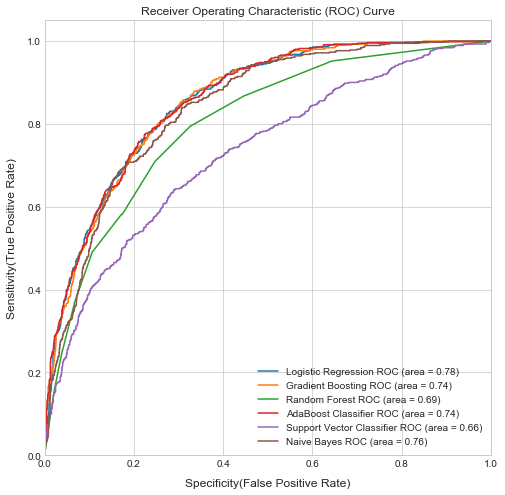

In [19]:
plt.figure(figsize=(8, 8))

# Iterate through the list of models
for m in models:
    model = m['model']  # select the model
    model.fit(X_train_res, y_train_res)  # train the model
    y_pred = model.predict(X_test)  # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    # Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test, model.predict(X_test))
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity(False Positive Rate)', fontsize=12, labelpad=10)
plt.ylabel('Sensitivity(True Positive Rate)', fontsize=12, labelpad=10)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
plt.legend(loc="lower right")
plt.show()
# plt.savefig('visualizations/ROC_curve.png', dpi=300)


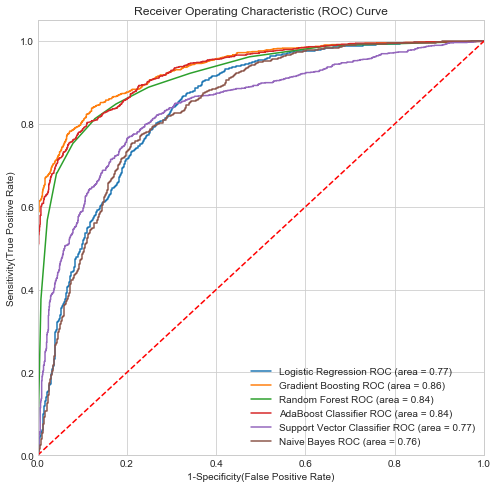

In [20]:
plt.figure(figsize=(8,8))

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': make_pipeline(StandardScaler(), LogisticRegression())
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'AdaBoost Classifier',
    'model': AdaBoostClassifier(),
},
{
    'label': 'Support Vector Classifier',
    'model': SVC(probability=True),
},
{
    'label': 'Naive Bayes',
    'model': GaussianNB(),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_2, y_train_2) # train the model
    y_pred=model.predict(X_test_2) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test_2, model.predict_proba(X_test_2)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test_2,model.predict(X_test_2))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('visualizations/ROC_curve.png')

In [21]:
param_grid = {'C': [0.1, 10.]}

clf = make_pipeline(StandardScaler(), 
                    GridSearchCV(LogisticRegression(),
                                 param_grid=param_grid,
                                 cv=2,
                                 refit=True))

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [22]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [23]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1549
           1       0.67      0.59      0.63       561

   micro avg       0.81      0.81      0.81      2110
   macro avg       0.76      0.74      0.75      2110
weighted avg       0.81      0.81      0.81      2110



In [24]:
df['churn'].value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [26]:
clf = make_pipeline(StandardScaler(), 
                    GridSearchCV(LogisticRegression(),
                                 param_grid={'C': [0.1, 1.0, 10.]},
                                 cv=3,
                                 refit=True))

In [27]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_c...}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0))])

In [28]:
new_x = pd.DataFrame(X_train)

In [29]:
new_x.shape

(4922, 24)

In [30]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_c...}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0))])

In [31]:
new = clf.predict(new_x)

In [33]:
print(classification_report(y_train, new))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3614
           1       0.65      0.53      0.59      1308

   micro avg       0.80      0.80      0.80      4922
   macro avg       0.75      0.72      0.73      4922
weighted avg       0.79      0.80      0.79      4922



### Logistic Regression Tuning

In [34]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())])
param_grid = [{'clf__C': [0.8, 1, 1.1, 1.2, 1.3, 1.5, 1.6], 'clf__class_weight': [None, 'balanced'],
               'clf__solver': ['liblinear', 'sag', 'saga']}]
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='recall')
gs.fit(X_train_res, y_train_res)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__C': [0.8, 1, 1.1, 1.2, 1.3, 1.5, 1.6], 'clf__class_weight': [None, 'balanced'], 'clf__solver': ['liblinear', 'sag', 'saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [35]:
gs.best_params_

{'clf__C': 1.5, 'clf__class_weight': None, 'clf__solver': 'liblinear'}

In [36]:
pred = gs.predict(X_test)

In [37]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1549
           1       0.52      0.83      0.64       561

   micro avg       0.75      0.75      0.75      2110
   macro avg       0.72      0.78      0.72      2110
weighted avg       0.82      0.75      0.76      2110



In [38]:
print(confusion_matrix(y_test, pred))

[[1113  436]
 [  93  468]]


In [39]:
np.median(gs.cv_results_['mean_test_score'])

0.813503043718871

In [40]:
pred = gs.predict(X_train)

In [41]:
print(classification_report(y_train, pred))
print(confusion_matrix(y_train, pred))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      3614
           1       0.52      0.81      0.63      1308

   micro avg       0.75      0.75      0.75      4922
   macro avg       0.72      0.77      0.72      4922
weighted avg       0.81      0.75      0.76      4922

[[2621  993]
 [ 246 1062]]


In [42]:
pred.shape

(4922,)

In [43]:
logistic_gain_2 = []
i_vals = []
cost = []
savings = []
i = .01

pred = gs.predict(X_train)

for i in np.linspace(0, 1, 101):
    folds = KFold(n_splits=5, shuffle=True)
    probs = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=folds, method='predict_proba', n_jobs=-1)
    probs = pd.DataFrame(probs)
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + (conf[1][0] * 500)
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    logistic_gain_2.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)

print(f'Max net gain = {max(logistic_gain_2)}')


Max net gain = 268500


### Logistic Regression Tuning

In [44]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(random_state=11))])
param_grid = [{'clf__C': [0.001, 0.1, 1.0], 'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=11, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__C': [0.001, 0.1, 1.0], 'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [45]:
gs.best_params_

{'clf__C': 1.0, 'clf__solver': 'newton-cg'}

In [46]:
np.median(gs.cv_results_['mean_train_score'])

0.8084532385286909

In [47]:
pred = gs.predict(X_train)

In [48]:
print(classification_report(y_train, pred))
print(confusion_matrix(y_train, pred))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      3614
           1       0.52      0.81      0.63      1308

   micro avg       0.75      0.75      0.75      4922
   macro avg       0.71      0.77      0.72      4922
weighted avg       0.81      0.75      0.76      4922

[[2619  995]
 [ 247 1061]]


In [49]:
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

**This is our winning model**

In [50]:
logistic_gain = []
i_vals = []
cost = []
savings = []
i = .01

pred = gs.predict(X_train)

for i in np.linspace(0, 1, 101):
    folds = KFold(n_splits=5, shuffle=True)
    probs = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=folds, method='predict_proba', n_jobs=-1)
    probs = pd.DataFrame(probs)
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + (conf[1][0] * 500)
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    logistic_gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)

print(f'Max net gain = {max(logistic_gain)}')


Max net gain = 268700


In [51]:
for i, v in enumerate(logistic_gain):
    if v == 272200:
        print(i)

In [52]:
probs = pd.DataFrame(gs.predict_proba(X_train))
new_pred = probs[1].apply(lambda x: 1 if x > 0.22 else 0)
conf = confusion_matrix(y_train, new_pred)
print(conf)

[[1718 1896]
 [  69 1239]]


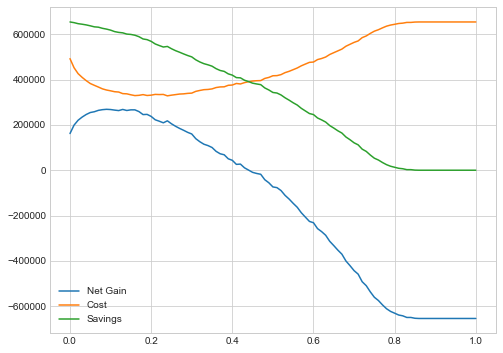

In [53]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, logistic_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

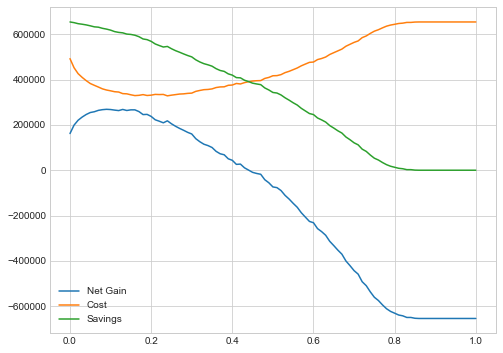

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, logistic_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

**Calculating our total cost and total savings to get net gain:**

In [55]:
conf = confusion_matrix(y_train, pred)

In [56]:
total_cost = (conf[0][1] * 100) + (conf[1][1] * 100)
total_savings = conf[1][1] * 500

In [57]:
net_gain = total_savings - total_cost
print(net_gain)

324900


In [58]:
gs.score(X_train, y_train)

0.8111620795107034

In [59]:
coeffs = gs.best_estimator_.named_steps['clf'].coef_[0]
list_of_coeffs = list(sorted(zip(coeffs * 10, X.columns)))


### Gradient Boosting Tuning

In [60]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', GradientBoostingClassifier())])
param_grid = [{'clf__learning_rate': [0.01, 0.1, 0.5, 1], 'clf__loss': ['deviance', 'exponential'],
               'clf__n_estimators': [50, 100, 150], 'clf__max_depth': [2, 3, 4]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__learning_rate': [0.01, 0.1, 0.5, 1], 'clf__loss': ['deviance', 'exponential'], 'clf__n_estimators': [50, 100, 150], 'clf__max_depth': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [61]:
gs.best_params_

{'clf__learning_rate': 0.1,
 'clf__loss': 'exponential',
 'clf__max_depth': 2,
 'clf__n_estimators': 50}

In [62]:
gs.best_score_

0.8367459878251245

In [63]:
np.median(gs.cv_results_['mean_test_score'])

0.7966242390702822

In [64]:
pred2 = gs.predict(X_train)
print(classification_report(y_train, pred2))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3614
           1       0.58      0.68      0.63      1308

   micro avg       0.79      0.79      0.79      4922
   macro avg       0.73      0.75      0.74      4922
weighted avg       0.80      0.79      0.79      4922



In [65]:
pred2 = gs.predict(X_train)
print(classification_report

SyntaxError: unexpected EOF while parsing (<ipython-input-65-7d31d402c54f>, line 2)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(i_vals, gradboost_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals, savings, label='Savings')
plt.legend(loc=0)
# plt.savefig('gradientboost_triple.svg')


### AdaBoost Tuning

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', AdaBoostClassifier())])
param_grid = [{'clf__learning_rate': [0.01, 0.1, 1], 'clf__algorithm': ['SAMME'], 'clf__n_estimators': [25, 50, 100]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)


In [ ]:
gs.best_params_

In [ ]:
np.median(gs.cv_results_['mean_test_score'])

In [ ]:
pred = gs.predict(X_train)
print(classification_report(y_train, pred))

In [ ]:
np.median(gs.cv_results_['mean_test_score'])

In [ ]:
pred = gs.predict(X_train)
print(classification_report(y_train, pred))

In [ ]:
np.median(gs.cv_results_['mean_test_score'])

In [ ]:
adaboost_gain = []
i_vals = []
cost = []
savings = []

pred = gs.predict(X_train)

for i in np.linspace(0.0, 1.0, 101):
    folds = KFold(n_splits=5, shuffle=True)
    probs = cross_val_predict(gs.best_estimator_, X=X_train, y=y_train, cv=folds, method='predict_proba', n_jobs=-1)
    probs = pd.DataFrame(probs)
    #     probs = pd.DataFrame(gs.predict_proba(X_train))
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    adaboost_gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)

print(f'Max net gain = {max(adaboost_gain)}')


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, adaboost_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

### Random Forest Tuning

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())])
param_grid = [{'clf__max_depth': [4, 5, 6], 'clf__max_features': [5, 10, 15, 20], 'clf__n_estimators': [50, 100, 150]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)


In [ ]:
gs.best_params_

In [ ]:
np.median(gs.cv_results_['mean_test_score'])

In [ ]:
pred = gs.predict(X_train)
print(classification_report(y_train, pred))

In [ ]:
# Test against our test set
gs.score(X_test, y_test)

In [ ]:
randforest_gain = []
i_vals = []
cost = []
savings = []

pred = gs.predict(X_train)

for i in np.linspace(0.0, 1.0, 101):
    folds = KFold(n_splits=5, shuffle=True)
    probs = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=folds, method='predict_proba', n_jobs=-1)
    probs = pd.DataFrame(probs)
    #     probs = pd.DataFrame(gs.predict_proba(X_train))
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    randforest_gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)

print(f'Max net gain = {max(randforest_gain)}')


#### Pickle lists so we don't have to run everything again

In [ ]:
def make_backups():
    with open('backups/randforest.pkl', 'wb') as f:
        pickle.dump(randforest_gain, f)
        
    with open('backups/logistic.pkl', 'wb') as f:
        pickle.dump(logistic_gain, f)
        
    with open('backups/gradboost.pkl', 'wb') as f:
        pickle.dump(gradboost_gain, f)
        
# make_backups()

#### Compute base cases where we predict all customers will churn, and none will churn

In [ ]:
y_train.shape

In [ ]:
new_pred_ones = np.ones(shape=(4922,))

conf = confusion_matrix(y_train, new_pred_ones)

total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
total_savings = conf[1][1] * 500

net_gain = total_savings - total_cost
print(net_gain)


In [ ]:
new_pred_zeros = np.zeros(shape=(4922,))

conf = confusion_matrix(y_train, new_pred_zeros)

total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
total_savings = conf[1][1] * 500

net_gain = total_savings - total_cost
print(net_gain)


In [ ]:
conf

In [ ]:
net_gain

#### Compute base case where we do nothing

In [ ]:
# 1308 customers will churn, at an average cost to replace of $500 each
# $654,000 loss, which is why our predictions bottom out at that number on the following chart (good to confirm that it does!)
1308 * 500

### Plot all Net Gain scores against each other

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(i_vals, logistic_gain, label='Logistic Regression', color='green', lw=2)
ax.axhline(y=0, color='black')
ax.set_xlabel('Probability Threshold', fontsize=16, labelpad=10)
ax.set_ylabel('$ Saved', rotation=90, fontsize=16, labelpad=10)
ax.set_yticklabels(['-100k', '0', '100k', '200k', '300k'], fontsize=12)
ax.set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5'], fontsize=12)
ax.set_yticks([-100000, 0, 100000, 200000, 300000])
ax.set_xbound(lower=0, upper=0.5)
ax.set_ybound(lower=-100000, upper=300000)
# plt.savefig('visualizations/net_cost_8.jpg', dpi=300)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(i_vals, logistic_gain, label='Logistic Regression', lw=2)
plt.plot(i_vals, randforest_gain, label='Random Forests', lw=2)
plt.plot(i_vals, gradboost_gain, label='Gradient Boost', lw=2)
plt.legend(loc=0)
ax.set_xlabel('Probability Threshold', fontsize=16, labelpad=10)
ax.set_ylabel('$ Saved', rotation=90, fontsize=16, labelpad=10)
ax.set_xbound(lower=0, upper=1)
# plt.savefig('visualizations/net_cost_9.jpg', dpi=300)


##  Cost minimization: 

In [ ]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs)
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

In [ ]:
cut = np.linspace(0, 1, 100)
cost = np.zeros_like(cut)
from sklearn.model_selection import KFold, cross_val_predict

obs = y_train

K = 20
for j in range(K):
    folds = KFold(n_splits=5, shuffle=True)
    prob = cross_val_predict(gs.best_estimator_, X_train, obs, cv=folds, method='predict_proba', n_jobs=5)[:, 1]
    getcost = makecost(obs, prob, falsepos_cost=100, falseneg_cost=500)
    currentcost = getcost(cut) / X.shape[0]
    cost += currentcost
    plt.plot(cut, currentcost, c='C0', alpha=0.05)
cost /= K
plt.plot(cut, cost, c='C0')
plt.xlabel('cutoff')
plt.ylabel('Expected cost per data point');


In [ ]:
bestcut = cut[np.argmin(cost)]
bestcut

In [ ]:
categories = ['Logistic Regression', 'AdaBoost', 'Random Forests', 'Gradient Boosting']
recall_pct = [0.81, 0.74, 0.72, 0.68]
net_gain = [272000, 257200, 262800, 263600]

In [ ]:
categories = ['Do nothing', 'Assume everyone will churn', 'Our model']
gain = [-654000, 162000, 272000]

fig, ax = plt.subplots(figsize=(8,8))
barlist = ax.bar(categories, gain, edgecolor='black')
ax.axhline(y=0, color='black')
ax.set_xticklabels(['Do\nnothing', 'Retain\neveryone', 'Our\nmodel'], fontsize=20)
ax.set_yticklabels(['-$600k', '-$400k', '-$200k', '$0', '200k','400k'], fontsize=20)
ax.set_yticks([-600000, -400000, -200000, 0, 200000, 400000])
ax.set_ybound(lower=-700000, upper=400000)
barlist[2].set_edgecolor('black')
plt.grid(axis='x')
# plt.savefig('visualizations/our_model.jpg', dpi=300)

In [ ]:
categories = ['Do nothing', 'Assume everyone will churn', 'Build a model']
gain = [-654000, 162000, 0]

fig, ax = plt.subplots(figsize=(8,8))
barlist = ax.bar(categories, gain, edgecolor='black')
ax.axhline(y=0, color='black')
ax.set_xticklabels(['Do\nnothing', 'Retain\neveryone', 'Build a\nmodel'], fontsize=20)
ax.set_yticklabels(['-$600k', '-$400k', '-$200k', '$0', '200k','400k'], fontsize=20)
ax.set_yticks([-600000, -400000, -200000, 0, 200000, 400000])
ax.set_ybound(lower=-700000, upper=400000)
plt.grid(axis='x')
# plt.savefig('visualizations/model_comparison.jpg', dpi=300)